### Example of Multi-label classification with PyTorch

Multi-label means that the same image can have associated several labels.

In other words: class are not exclusive

we will be using the **HBKU2019 dataset (from Kaggle)**

In this NB we're using EffNet B2

In [1]:
import os
import time
import random
import pandas as pd
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import models

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from PIL import Image

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# globals

SEED = 42

BASE_DIR = "/home/datascience/hbku2019-dataset/"
# file with labels
DATA_CSV = BASE_DIR + 'labels/labels_train.csv'
# dir with images
IMAGE_DIR = BASE_DIR + "imgs/train/"

# Img model input size
IM_SIDE = 260

# reading the categories
cats = pd.read_csv(BASE_DIR + 'labels/categories.csv', header=None)
cats = list(cats[0])

# Number of classes
N_CLASSES = len(cats)

print(cats)
print(len(cats))

['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
80


In [3]:
class CustomDatasetFromCSV(Dataset):
    def __init__(self, df, image_path, transformations):
        """
        Args:
            df: the dataframe with train or val rows
            image_path: path to dir of images
            transform: pytorch transforms for transforms and tensor conversion
        """
        # Transforms
        self.transforms = transformations
        
        # store the df
        self.data_info = df
        
        # First column contains the image paths
        self.image_arr = self.data_info.iloc[:, 0].values
  
        # remaining columns are the labels
        self.label_arr = self.data_info.iloc[:, 1:].values

        # Calculate len
        self.data_len = len(self.label_arr)
        
        # image_path
        self.image_path = image_path

    def __getitem__(self, index):
        # Get image name from the pandas df
        image_name = self.image_arr[index]
        
        # Open image
        # to RGB is needed, some imgs are grayscale
        img = Image.open(self.image_path + image_name).convert("RGB")

        if self.transforms is not None:
            # do the resize and normalize (based on ImageNet)
            img = self.transforms(img)
        
        # Get labels of the image
        single_image_label = self.label_arr[index]
        
        # simula input addizionale
        x1 = torch.ones((1, 3))

        return (img, x1, single_image_label)

    def __len__(self):
        return self.data_len

In [4]:
# Let's take a look at the data we have. To do it we need to load the dataset without augmentations.
# read all images names and labels
data = pd.read_csv(DATA_CSV, header=None)

# split for train, val
train_df, val_df = train_test_split(data, test_size=0.2, random_state=SEED, shuffle=True)

In [5]:
# Transformations on Images
IMAGE_SIDE = 260

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIDE, IMAGE_SIDE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Train preprocessing
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIDE, IMAGE_SIDE)),
    transforms.RandomHorizontalFlip(),
    # added to fight overfitting
    transforms.RandomRotation(25),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# train and validation datasets
train_ds = CustomDatasetFromCSV(train_df, IMAGE_DIR, train_transform)
val_ds = CustomDatasetFromCSV(val_df, IMAGE_DIR, val_transform)

In [6]:
print(f"We have {N_CLASSES} classes...")

We have 80 classes...


In [19]:
# Model class definition
# we can choose a different backbone

# Use the torchvision's implementation of EFFNetB2
# but add FC layer for a different number of classes (27) 
# and a Sigmoid for multi-label (not exclusive)
class EFFNetB2(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        effnetb2 = models.efficientnet_b2(pretrained=True)
        
        effnetb2.classifier[1] = nn.Sequential(nn.Linear(1408, n_classes, bias=True))
        
        self.base_model = effnetb2
        self.sigm = nn.Sigmoid()
    
    # modified for the hybrid network
    # it works, we need only to modify the network to process
    # also the structured data
    def forward(self, x, x1):
        # x: image
        # x1 structured data []
        return self.sigm(self.base_model(x))

In [20]:
# Initialize the dataloaders for training.
BATCH_SIZE = 32
NUM_WORKERS = 4

train_data_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, 
                               num_workers=NUM_WORKERS, shuffle=True, drop_last=True)
val_data_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

In [21]:
print("Datasets:")
print(f"We have {len(train_ds)} samples in train dataset")
print(f"We have {len(val_ds)} samples in validation dataset")

Datasets:
We have 78219 samples in train dataset
We have 19555 samples in validation dataset


In [22]:
# Initialize the model
device = torch.device('cuda')

model = EFFNetB2(N_CLASSES)

model = model.to(device)

In [23]:
model

EFFNetB2(
  (base_model): EfficientNet(
    (features): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): ConvNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_activ

In [24]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has: {count_parameters(model)} trainable params...")

The model has: 7813714 trainable params...


In [25]:
def calculate_metrics(pred, target, threshold=0.5):
    pred = np.array(pred > threshold, dtype=float)
    
    return {'micro/precision': precision_score(y_true=target, y_pred=pred, average='micro'),
            'micro/recall': recall_score(y_true=target, y_pred=pred, average='micro'),
            'micro/f1': f1_score(y_true=target, y_pred=pred, average='micro'),
            'macro/precision': precision_score(y_true=target, y_pred=pred, average='macro'),
            'macro/recall': recall_score(y_true=target, y_pred=pred, average='macro'),
            'macro/f1': f1_score(y_true=target, y_pred=pred, average='macro'),
            'samples/precision': precision_score(y_true=target, y_pred=pred, average='samples'),
            'samples/recall': recall_score(y_true=target, y_pred=pred, average='samples'),
            'samples/f1': f1_score(y_true=target, y_pred=pred, average='samples'),
            }

In [26]:
EPOCHS = 2
# lowered respect to tresnet
LR = 2e-4

# Loss
criterion = nn.BCELoss()
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Logs - Helpful for plotting after training finishes
train_logs = {"loss": [], "accuracy": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "time": []}

In [27]:
def train_one_epoch(train_data_loader):

    # Local Parameters
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()
    
    model.train()
    
    # simulate
    sum_x1 = 0.
    
    for images, x1, labels in tqdm(train_data_loader):

        # Loading images and labels to device
        images = images.to(device)
        labels = labels.to(device)
        x1 = x1.to(device)
        
        # Resetting Gradients
        optimizer.zero_grad()

        # Forward
        preds = model(images, x1)

        sum_x1 += x1
        
        # Calculating Loss
        _loss = criterion(preds, labels.type(torch.float))
        loss = _loss.item()
        epoch_loss.append(loss)

        # Backward
        _loss.backward()
        optimizer.step()

    # Overall Epoch Results 
    total_time = time.time() - start_time

    # Acc and Loss
    epoch_loss = np.mean(epoch_loss)

    # Storing results to logs
    train_logs["loss"].append(epoch_loss)
    train_logs["time"].append(total_time)
    
    return epoch_loss, total_time

In [28]:
def val_one_epoch(val_data_loader):

    # Local Parameters
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()
    
    model.eval()
    
    for images, x1, labels in val_data_loader:

        # Loading images and labels to device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward
        preds = model(images)

        # Calculating Loss
        _loss = criterion(preds, labels.type(torch.float))
        loss = _loss.item()
        epoch_loss.append(loss)

    # Overall Epoch Results
    total_time = time.time() - start_time

    # Acc and Loss
    epoch_loss = np.mean(epoch_loss)

    val_logs["loss"].append(epoch_loss)
    val_logs["time"].append(total_time)

    return epoch_loss, total_time 

In [29]:
#
# Here we do the training loop
#
for epoch in range(EPOCHS):
    # Training
    loss, _time = train_one_epoch(train_data_loader)

    print()
    print(
        f"Training: Epoch {epoch}, Loss : {round(loss, 4)}, Time : {round(_time, 1)}"
    )

    # Validation
    loss, _time, = val_one_epoch(val_data_loader)

    print()
    print(
        f"Validation: Epoch {epoch}, Loss : {round(loss, 4)}, Time : {round(_time, 1)}"
    )

  2%|▏         | 57/2444 [00:15<11:01,  3.61it/s]


KeyboardInterrupt: 

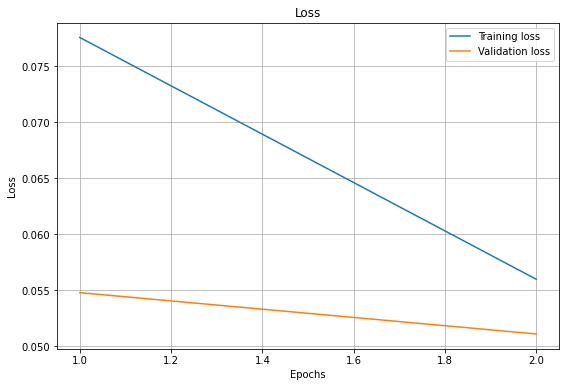

In [18]:
vet_epochs = np.arange(1, EPOCHS+1, 1)

# Loss
plt.figure(figsize=(9, 6))
plt.title("Loss")
plt.plot(vet_epochs, train_logs["loss"], label="Training loss")
plt.plot(vet_epochs, val_logs["loss"], label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

La curva riportata sopra è un chiaro esempio di overfitting: dopo la epoch 4 la training loss continua a diminuire mentre la validation loss comincia a salire

#### Compute metrics on the entire validation set (needs to be done on GPU, or is too slow)

In [ ]:
# torch.save(model, "hbku2019.pt")

In [ ]:
model = torch.load('hbku2019.pt')

In [ ]:
val_data_loader = DataLoader(val_ds, batch_size=32, num_workers=4)

In [ ]:
device = torch.device('cuda')
# reload the model

# model.to(device)
model.eval()

all_preds = []
all_labels = []

for images, labels in tqdm(val_data_loader):
    with torch.no_grad():
        images = images.to(device)
        labels = labels
    
        # Forward
        preds = model(images).to("cpu")
    
        all_preds.append(preds.numpy())
        all_labels.append(labels.numpy())

In [ ]:
all_preds_flatten = [item for sublist in all_preds for item in sublist]

In [ ]:
all_labels_flatten = [item for sublist in all_labels for item in sublist]

In [ ]:
out = calculate_metrics(np.array(all_preds_flatten), np.array(all_labels_flatten))

#### Results on validation set

In [ ]:
# reduce decimal to 3
for key in out.keys():
    out[key] = round(out[key], 3)

In [ ]:
out